based on [this](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

# 1. Load the packages

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import stopwordsiso

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# 2. Import Newsgroups Text Data

In [2]:
# Import Dataset
df = pd.read_csv("../02 - Analise exploratoria/all_together.csv")
df.head()

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,file,link,category,emotiveness,errors,pausatility,text,tokens,words in upper case,average sentence length,nouns,verbs,adverbs,adjectives,pronouns,date
0,fake,1.txt,ceticismopolitico.com,politica,0.263158,0.000000,2.000000,"katia abreu diz vai colocar expulsao moldura, ...",211.0,6.0,14.23080,46.0,30.0,13.0,7.0,26.0,2017-11-30
1,fake,10.txt,ceticismopolitico.com,politica,0.241667,0.007874,2.500000,"dr. ray peita bolsonaro, chama-o conservador f...",289.0,0.0,18.14290,64.0,56.0,18.0,11.0,20.0,2017-11-24
2,fake,100.txt,afolhabrasil.com.br,politica,0.127820,0.003636,1.812500,reinaldo azevedo desmascarado policia federal....,304.0,0.0,17.18750,88.0,45.0,8.0,9.0,18.0,2017-05-23
3,fake,1000.txt,diariodobrasil.org,politica,0.229008,0.001748,2.680000,relatorio assustador bndes mostra dinheiro pub...,639.0,14.0,22.88000,175.0,87.0,21.0,39.0,34.0,2017-07-24
4,fake,1001.txt,diariodobrasil.org,politica,0.269231,0.000000,0.894737,"radialista americano fala sobre pt: ""eles vend...",128.0,1.0,5.84211,31.0,21.0,8.0,6.0,12.0,2017-07-25


In [3]:
print("All categories:", set(df["category"]))

df_politica = df.loc[df["category"] == "politica"].copy()
print(f"Ratio: {len(df_politica)}/{len(df)}")

df_politica.head()

All categories: {'politica', 'economia', 'sociedade_cotidiano', 'religiao', 'ciencia_tecnologia', 'tv_celebridades'}
Ratio: 4180/7200


C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,file,link,category,emotiveness,errors,pausatility,text,tokens,words in upper case,average sentence length,nouns,verbs,adverbs,adjectives,pronouns,date
0,fake,1.txt,ceticismopolitico.com,politica,0.263158,0.000000,2.000000,"katia abreu diz vai colocar expulsao moldura, ...",211.0,6.0,14.23080,46.0,30.0,13.0,7.0,26.0,2017-11-30
1,fake,10.txt,ceticismopolitico.com,politica,0.241667,0.007874,2.500000,"dr. ray peita bolsonaro, chama-o conservador f...",289.0,0.0,18.14290,64.0,56.0,18.0,11.0,20.0,2017-11-24
2,fake,100.txt,afolhabrasil.com.br,politica,0.127820,0.003636,1.812500,reinaldo azevedo desmascarado policia federal....,304.0,0.0,17.18750,88.0,45.0,8.0,9.0,18.0,2017-05-23
3,fake,1000.txt,diariodobrasil.org,politica,0.229008,0.001748,2.680000,relatorio assustador bndes mostra dinheiro pub...,639.0,14.0,22.88000,175.0,87.0,21.0,39.0,34.0,2017-07-24
4,fake,1001.txt,diariodobrasil.org,politica,0.269231,0.000000,0.894737,"radialista americano fala sobre pt: ""eles vend...",128.0,1.0,5.84211,31.0,21.0,8.0,6.0,12.0,2017-07-25


In [4]:
# Easier to do as a string
df_2017 = df_politica.loc[df["date"].str.startswith("2017", na=False)].copy()


print(f"Ratio: {len(df_2017)}/{len(df)} ({len(df_2017)/len(df):.2f})")
print(f"True: {len(df_2017.loc[df['label'] == 'true'])}")
print(f"Fake: {len(df_2017.loc[df['label'] == 'fake'])}")
df = df_2017

print(df_2017.head())

Ratio: 1718/7200 (0.24)
True: 936
Fake: 782
  label      file                   link  category  emotiveness    errors  \
0  fake     1.txt  ceticismopolitico.com  politica     0.263158  0.000000   
1  fake    10.txt  ceticismopolitico.com  politica     0.241667  0.007874   
2  fake   100.txt    afolhabrasil.com.br  politica     0.127820  0.003636   
3  fake  1000.txt     diariodobrasil.org  politica     0.229008  0.001748   
4  fake  1001.txt     diariodobrasil.org  politica     0.269231  0.000000   

   pausatility                                               text  tokens  \
0     2.000000  katia abreu diz vai colocar expulsao moldura, ...   211.0   
1     2.500000  dr. ray peita bolsonaro, chama-o conservador f...   289.0   
2     1.812500  reinaldo azevedo desmascarado policia federal....   304.0   
3     2.680000  relatorio assustador bndes mostra dinheiro pub...   639.0   
4     0.894737  radialista americano fala sobre pt: "eles vend...   128.0   

   words in upper case  averag

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 3. Tokenize and Clean-up using gensim’s simple_preprocess()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))


all_documents = list(df["text"].copy())
data_words = list(sent_to_words(all_documents))
data_words[0]

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['katia',
 'abreu',
 'diz',
 'vai',
 'colocar',
 'expulsao',
 'moldura',
 'reclamar',
 'senadora',
 'katia',
 'abreu',
 'sem',
 'partido',
 'to',
 'disse',
 'expulsao',
 'pmdb',
 'resultado',
 'acao',
 'cupula',
 'atual',
 'legenda',
 'que',
 'segundo',
 'ela',
 'oportunista',
 'amanha',
 'vou',
 'botar',
 'moldura',
 'dourada',
 'expulsao',
 'porque',
 'maos',
 'onde',
 'veio',
 'atestado',
 'boa',
 'conduta',
 'curriculo',
 'essas',
 'pessoas',
 'expulsaram',
 'servem',
 'pais',
 'eles',
 'servem',
 'pais',
 'beneficios',
 'proprios',
 'disse',
 'katia',
 'abreu',
 'ue',
 'expulsao',
 'algo',
 'tao',
 'bom',
 'curriculo',
 'tanta',
 'choradeira',
 'katia',
 'sabemos',
 'motivo',
 'provavelmente',
 'katia',
 'valor',
 'pt',
 'partido',
 'deveria',
 'te',
 'la',
 'absorvido',
 'ao',
 'parece',
 'pt',
 'gostava',
 'katia',
 'somente',
 'ficasse',
 'entrincheirada',
 'dentro',
 'pmdb',
 'ou',
 'seja',
 'rebaixar',
 'demais',
 'resta',
 'katia',
 'ficar',
 'chorando',
 'pitangas',
 'todos

# 4. Lemmatization

Lemmatization is a process where we convert words to its root word.

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

## If you're unable to run the cell below, make sure you have pt_core_news_sm from spacy.

### To download it, run `python -m spacy download pt_core_news_sm`

In [6]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            " ".join(
                [
                    token.lemma_ if token.lemma_ not in ["-PRON-"] else ""
                    for token in doc
                    if token.pos_ in allowed_postags
                ]
            )
        )
    return texts_out


# Initialize spacy 'pt_core_news_sm' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_sm", disable=["parser", "ner"])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(
    data_words, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
)
data_lemmatized[0]

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'katia abreu dizer colocar expulsao moldurar reclamar abreu partir dizer expulsao pmdb resultar cupula atual legendar oportunista amanhar botar moldurar dourar expulsao maos vir atestar bom conduta curriculo pessoa expulsar servir pai servir pai beneficios proprios dizer katia abreu expulsao bom curriculo tanto choradeira katia saber motivar provavelmente katia valor pt partir dever absorver parecer gostar katia somente ficar entrincheirar dentro pmdb rebaixar demais restar katia ficar chorar pitanga canto momento cadastrar abreu fileira situacao patetica ministro agricultura'

## Remove stopwords

In [7]:
stops = set(stopwordsiso.stopwords("pt"))


def remove_stopwords(text: str) -> str:
    # print(text)
    return " ".join([t for t in text.split(" ") if t not in stops])


data_no_stopwords = [remove_stopwords(text) for text in data_lemmatized]
data_no_stopwords[0]

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'katia abreu colocar expulsao moldurar reclamar abreu expulsao pmdb resultar cupula atual legendar oportunista amanhar botar moldurar dourar expulsao maos vir atestar conduta curriculo pessoa expulsar servir pai servir pai beneficios proprios katia abreu expulsao curriculo choradeira katia motivar provavelmente katia pt dever absorver parecer gostar katia ficar entrincheirar pmdb rebaixar restar katia ficar chorar pitanga canto cadastrar abreu fileira situacao patetica ministro agricultura'

# 5. Create the Document-Word matrix

The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer. 

We configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in portuguese stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 2 in order to be qualified as a word.

So, to create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.

Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.

If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [8]:
vectorizer = CountVectorizer(
    analyzer="word",
    min_df=10,  # minimum reqd occurences of a word
    #  stop_words='portuguese',             # remove stop words
    lowercase=True,  # convert all words to lowercase
    token_pattern="[a-zA-Z0-9]{2,}",  # num chars > 2
    # max_features=50000,             # max number of uniq words
)
data_vectorized = vectorizer.fit_transform(data_no_stopwords)

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 6. Check Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, we are interested in knowing what percentage of cells contain non-zero values.

In [9]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print(f"Sparsicity: {((data_dense > 0).sum()/data_dense.size)*100} %")

Sparsicity: 3.4748787290549727 %


C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 7. Build LDA model with sklearn

Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.

For this example, we have set the n_components based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(
    n_components=5,  # Number of topics
    max_iter=10,  # Max learning iterations
    learning_method="online",
    random_state=100,  # Random state
    batch_size=128,  # n docs in each learning iter
    evaluate_every=-1,  # compute perplexity every n iters, default: Don't
    n_jobs=None,  # Use all available CPUs
)
lda_output = lda_model.fit_transform(data_vectorized)

lda_model  # Model attributes

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=100)

# 8. Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -2980283.447532351
Perplexity:  1459.602384458317
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# 9. How to GridSearch the best LDA model?

The most important tuning parameter for LDA models is n_components (number of topics). In addition, we are going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [12]:
_filename_model = "model_lda.obj"
import pickle, os


def load_model():
    if os.path.exists(_filename_model):
        with open(_filename_model, "rb") as f:
            return pickle.load(f)
    return None


def save_model(model):
    with open(_filename_model, "wb") as f:
        pickle.dump(model, f)

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Define Search Param
search_params = {
    "n_components": [3, 5, 7],
    "learning_decay": [0.5, 0.7, 0.9],
    "learning_method": ["online"],
}

# Init the Model
lda = LatentDirichletAllocation()

_model = load_model()
if _model is None:
    # Init Grid Search Class
    _model = GridSearchCV(lda, param_grid=search_params)
    # Do the Grid Search
    _model.fit(data_vectorized)
    save_model(_model)

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [14]:
model = load_model()
print(model)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['online'],
                         'n_components': [3, 5, 7]})


C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 10. How to see the best topic model and its parameters?

In [15]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 3}
Best Log Likelihood Score:  -621096.7967477266
Model Perplexity:  1522.6166294491027


# 11. Compare LDA Model Performance Scores

In [16]:
model.cv_results_.keys()

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_decay', 'param_learning_method', 'param_n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

# Get Log Likelyhoods from Grid Search Output
n_topics = [3, 5, 7]
log_likelyhoods_5 = [
    round(model.cv_results_["mean_test_score"][i])
    for i, learning_decay in enumerate(model.cv_results_["param_learning_decay"])
    if learning_decay == 0.5
]
log_likelyhoods_7 = [
    round(model.cv_results_["mean_test_score"][i])
    for i, learning_decay in enumerate(model.cv_results_["param_learning_decay"])
    if learning_decay == 0.7
]
log_likelyhoods_9 = [
    round(model.cv_results_["mean_test_score"][i])
    for i, learning_decay in enumerate(model.cv_results_["param_learning_decay"])
    if learning_decay == 0.9
]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label="0.5")
plt.plot(n_topics, log_likelyhoods_7, label="0.7")
plt.plot(n_topics, log_likelyhoods_9, label="0.9")
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title="Learning decay", loc="best")
plt.show()

# 12. How to see the dominant topic in each document?

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table below, we’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [17]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = [f"Topic {i}" for i in range(best_lda_model.n_components)]

# index names
docnames = [f"Doc {i}" for i in range(len(all_documents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(
    np.round(lda_output, 2), columns=topicnames, index=docnames
)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic

# Styling
def color_green(val):
    color = "green" if val > 0.1 else "black"
    return "color: {col}".format(col=color)


def make_bold(val):
    weight = 700 if val > 0.1 else 400
    return "font-weight: {weight}".format(weight=weight)


# Apply Style
df_document_topics = (
    df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
)
df_document_topics

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0,Topic 1,Topic 2,dominant_topic
Doc 0,0.010000,0.010000,0.980000,2
Doc 1,0.000000,0.000000,0.990000,2
Doc 2,0.810000,0.110000,0.080000,0
Doc 3,0.000000,0.500000,0.500000,1
Doc 4,0.010000,0.010000,0.980000,2
Doc 5,0.150000,0.010000,0.840000,2
Doc 6,0.030000,0.270000,0.710000,2
Doc 7,0.120000,0.660000,0.220000,1
Doc 8,0.010000,0.320000,0.670000,2
Doc 9,0.870000,0.120000,0.010000,0


# 13. Review topics distribution across documents

In [18]:
df_topic_distribution = (
    df_document_topic["dominant_topic"].value_counts().reset_index(name="Num Documents")
)
df_topic_distribution.columns = ["Topic Num", "Num Documents"]
df_topic_distribution

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic Num,Num Documents
0,2,720
1,1,508
2,0,490


# 14. How to visualize the LDA model with pyLDAvis?

The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic.

In [19]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(
    best_lda_model, data_vectorized, vectorizer, mds="tsne"
)
panel

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  41.496522
1      -387.996002  -373.316162       2        1  35.170774
0     -2184.745605   -60.565800       3        1  23.332704, topic_info=           Term         Freq        Total Category  logprob  loglift
3645    senador  1495.000000  1495.000000  Default  30.0000  30.0000
3835      temer  3192.000000  3192.000000  Default  29.0000  29.0000
2757  odebrecht  1203.000000  1203.000000  Default  28.0000  28.0000
105       aecio   900.000000   900.000000  Default  27.0000  27.0000
2589  ministrar  2243.000000  2243.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3264   publicar   449.244825  2137.945906   Topic3  -5.3587  -0.1047
1743     feirar   383.749591  1234.782878   Topic3  -5.5163   0.2867
2889     passar   374.517716  1398.128884   Topic3  -5.5406   0.1381
3159     prisao   359.163751   964.232702   Topic3  -5.5825   0.4678
118     afirmar   372.813402  2478.402571   Topic3  -5.5452  -0.4390

[272 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
41        2  0.983442  acervar
61        1  0.229990  acordar
61        2  0.565392  acordar
61        3  0.204190  acordar
104       1  0.053502  advogar
...     ...       ...      ...
4083      3  0.198021   voltar
4102      2  0.961810   zelote
4102      3  0.032060   zelote
4103      1  0.052396     zeze
4103      3  0.943132     zeze

[578 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

# 15. How to see the Topic’s keywords?

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [20]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,abaixar,abalar,abandonar,abastecer,abastecido,abastecimento,abater,abertamente,aberto,abertura,...,wagner,weber,wesley,whatsapp,zanin,zavascki,zelar,zelote,zeze,zonar
Topic 0,131.120494,4.072755,2.431854,1.224190,0.376491,3.382533,1.191862,5.875635,39.955376,74.431254,...,4.280383,7.697074,1.683523,13.258062,0.386236,59.592004,0.744087,0.533344,50.578741,50.861002
Topic 1,160.949127,1.444133,0.539964,14.371163,12.116168,18.915445,9.183873,1.733475,65.378464,75.311085,...,6.673319,9.093159,7.254982,1.060490,16.439992,13.159250,11.237809,31.783595,0.450153,20.118019
Topic 2,154.305402,9.351850,62.265544,14.775551,2.070136,15.440309,3.946649,5.754228,122.948198,54.453867,...,2.298251,11.754090,5.339303,17.200302,0.378417,2.833375,3.365741,0.446612,3.291609,75.524420


# 16. Get the top 15 keywords each topic

From the above output, we want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [21]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(
    vectorizer=vectorizer, lda_model=best_lda_model, n_words=15
)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = [
    "Word " + str(i) for i in range(df_topic_keywords.shape[1])
]
df_topic_keywords.index = ["Topic " + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,temer,senador,presidente,ministrar,aecio,federal,policiar,deputar,pmdb,denunciar,pedir,republicar,senado,casar,janot
Topic 1,presidente,federal,pedir,afirmar,odebrecht,lavar,dinheiro,jato,defeso,empresar,propinar,milhoes,depoimento,ministrar,publicar
Topic 2,presidente,governar,pai,temer,politicar,deputar,pessoa,afirmar,publicar,brasileiro,passar,ficar,casar,querer,direito


# 17. How to cluster documents that share similar topics and plot?

We can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has N clusters, I’ve set n_clusters=N in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [22]:
# Construct the k-means clusters
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print(
    "Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2)
)

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Component's weights: 
 [[ 0.36  0.4   0.85]
 [ 0.28  0.82 -0.5 ]]
Perc of Variance Explained: 
 [0.08 0.53]


In [23]:
clusters

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([2, 2, 0, ..., 2, 0, 0])

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


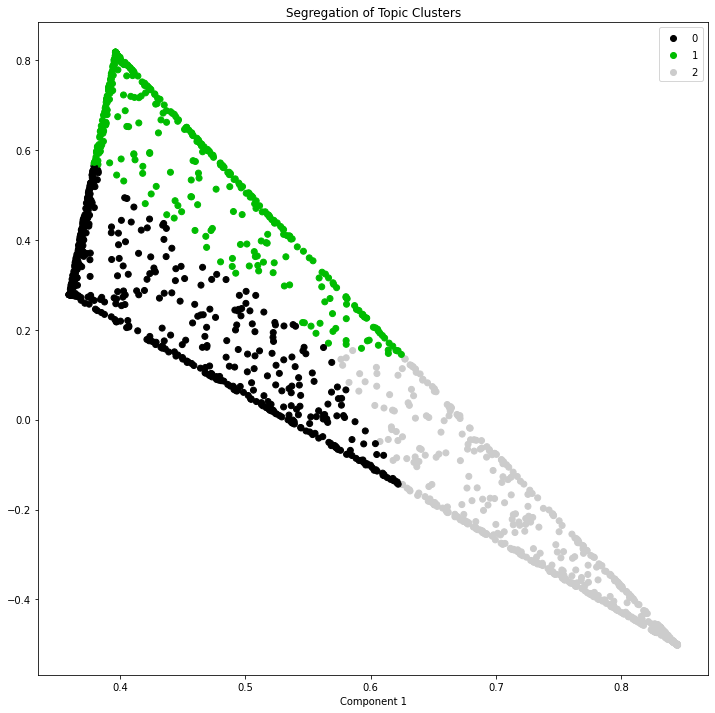

In [24]:
# Plot
import matplotlib.cm as cm

plt.figure(figsize=(12, 12))
ax = plt.scatter(x, y, c=clusters, cmap=cm.nipy_spectral)
plt.xlabel("Component 2")
plt.xlabel("Component 1")
plt.title(
    "Segregation of Topic Clusters",
)
plt.legend(*ax.legend_elements())

plt.show()

# Fazendo uns gráficos da evolução dos tópicos pelo tempo

In [25]:
#len(y)
df_2017.index = df_document_topic.index
df_document_topic.loc[:, 'date'] = df_2017['date']
df_document_topic.loc[:, 'label'] = df_2017['label']
df_document_topic["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
df_document_topic["period"] = df_document_topic["date"].dt.to_period("m")
df_document_topic

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0,Topic 1,Topic 2,dominant_topic,date,label,period
Doc 0,0.01,0.01,0.98,2,2017-11-30,fake,2017-11
Doc 1,0.00,0.00,0.99,2,2017-11-24,fake,2017-11
Doc 2,0.81,0.11,0.08,0,2017-05-23,fake,2017-05
Doc 3,0.00,0.50,0.50,1,2017-07-24,fake,2017-07
Doc 4,0.01,0.01,0.98,2,2017-07-25,fake,2017-07
...,...,...,...,...,...,...,...
Doc 1713,0.00,0.00,1.00,2,2017-01-27,true,2017-01
Doc 1714,0.00,1.00,0.00,1,2017-06-30,true,2017-06
Doc 1715,0.00,0.00,1.00,2,2017-09-19,true,2017-09
Doc 1716,0.29,0.37,0.34,1,2017-07-28,true,2017-07


In [26]:
df_document_topic.groupby(['dominant_topic', 'label']).count()

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0  Topic 1  Topic 2  date  period
dominant_topic label                                         
0              fake       252      252      252   252     252
               true       238      238      238   238     238
1              fake       193      193      193   193     193
               true       315      315      315   315     315
2              fake       337      337      337   337     337
               true       383      383      383   383     383

In [27]:
print(df_document_topic.groupby(['dominant_topic']).count()['label'])

df_2 = df_document_topic.copy()
df_3 = pd.DataFrame(columns=['dominant_topic', 'label', 'period', 'Topic 0'])
for i in range(0,3):
    df_ = df_2[df_2['dominant_topic'] == i].groupby(['dominant_topic', 'label', 'period']).count().reset_index()[['dominant_topic', 'label', 'period', 'Topic 0']]
    df_['Topic 0'] = df_['Topic 0'] * 100 / df_['Topic 0'].sum()
    df_3 = df_3.append(df_, ignore_index=True)

df_3

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dominant_topic
0    490
1    508
2    720
Name: label, dtype: int64


,dominant_topic,label,period,Topic 0
0,0,fake,2017-01,6.530612
1,0,fake,2017-02,5.714286
2,0,fake,2017-03,3.469388
3,0,fake,2017-04,2.857143
4,0,fake,2017-05,9.591837
...,...,...,...,...
67,2,true,2017-08,4.583333
68,2,true,2017-09,4.444444
69,2,true,2017-10,6.388889
70,2,true,2017-11,5.555556


C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


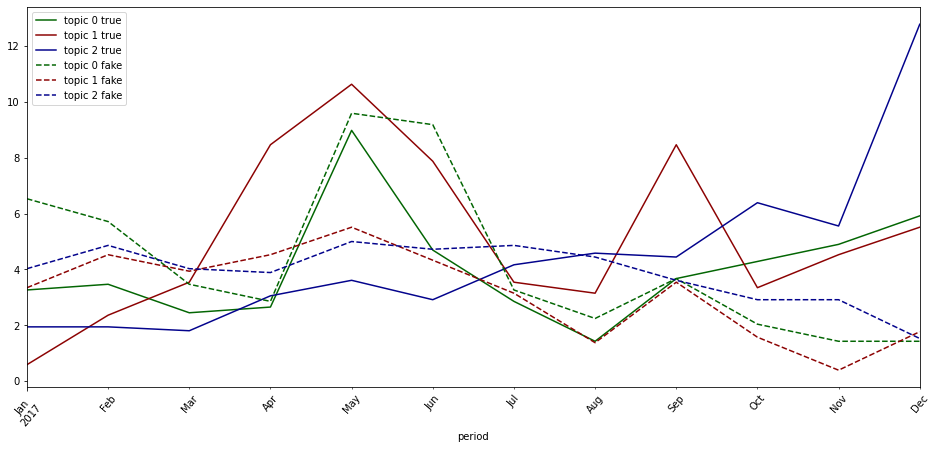

In [28]:
i = -0.5
for l in ['true', 'fake']:
    if l == 'true':
        d = {0: "darkgreen", 1: "darkred", 2: "darkblue"}
        line = '-'
    else:
        d = {0: "lightgreen", 1: "indianred", 2: "royalblue"}
        line = '--'
    d = {0: "darkgreen", 1: "darkred", 2: "darkblue"}
    for k, c in d.items():
        i += 1
        ax = (
            df_3[(df_3["dominant_topic"] == k) & (df_3['label'] == l)][['period', 'Topic 0']]
            .groupby("period")["Topic 0"]
            .sum()
            .plot(
                figsize=(16, 7),
                label='topic ' + str(k) + ' ' + l,
                alpha=0.99,
                rot=50,
                legend=True,
                linestyle=line,
                color=c
                )
            )
plt.show()

C:\Users\Xinda\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


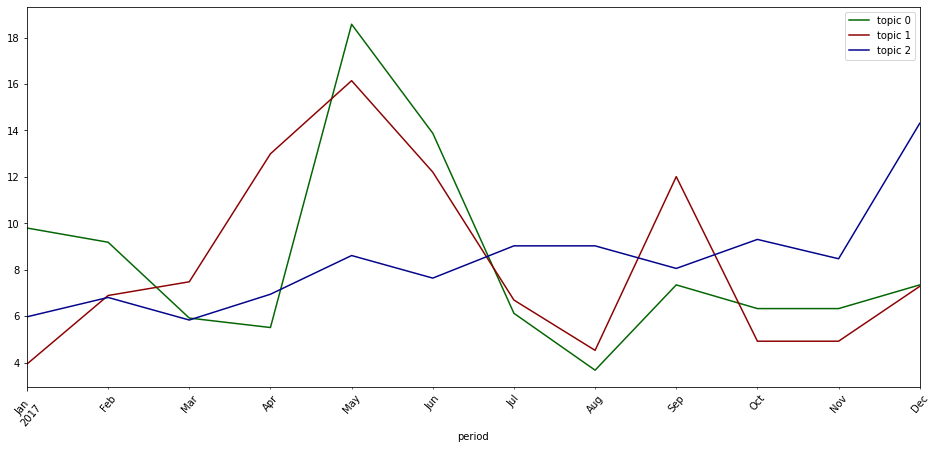

In [29]:
df_document_topic["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
df_document_topic["period"] = df_document_topic["date"].dt.to_period("m")

i = -0.5

d = {0: "darkgreen", 1: "darkred", 2: "darkblue"}
line = '-'
for k, c in d.items():
    i += 1
    ax = (
        df_3[(df_3["dominant_topic"] == k)][['period', 'Topic 0']]
        .groupby("period")["Topic 0"]
        .sum()
        .plot(
            figsize=(16, 7),
            label='topic ' + str(k),
            alpha=0.99,
            rot=50,
            legend=True,
            linestyle=line,
            color=c
            )
        )
plt.show()